## Imports and I/O

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mod_name_dict = {
    'OLS': 'Linear: OLS',
    'LASSO': 'Linear: OLS',
    'PLS': 'Linear: PC',
    'PCR': 'Linear: PC',
    'SVR': 'Linear: SVR',
    'RF': 'Non-parametric: DT',
    'GBR': 'Non-parametric: DT'
}

In [3]:
df_plot = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_tmp.csv')
df_spatial = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_tmp.csv')
df_ecosite = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_tmp.csv')
df_year = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_tmp.csv')

t_plot = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_results_plot.csv')
t_spatial = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_results_plot.csv')
t_ecosite = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_results_plot.csv')
t_year = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_results_plot.csv')

In [4]:
df_boots_yr_transect = pd.read_csv('./results/tmp/vor_bootstrap_by_year_transect.csv')

In [5]:
df_plot['cv'] = 'Plot'
df_spatial['cv'] = 'Spatial'
df_ecosite['cv'] = 'Ecosite'
df_year['cv'] = 'Year'

t_plot['cv'] = 'Plot'
t_spatial['cv'] = 'Spatial'
t_ecosite['cv'] = 'Ecosite'
t_year['cv'] = 'Year'

In [6]:
t_all = pd.concat([t_plot, t_spatial, t_ecosite, t_year])
t_all = t_all[t_all['Source'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].copy()
t_all['Source_type'] = t_all['Source'].apply(lambda x: mod_name_dict[x])
t_all['cv'] = t_all['cv'].apply(lambda x: 'Pasture (block)' if x == 'Spatial' else 'Plot (random)' if x == 'Plot' else x)
t_all.columns

Index(['Source', 'MAE', 'MAE_std', 'Bias', 'Bias_std', 'R^2', 'R^2_std', 'r',
       'r_std', 'MAE_bt', 'MAE_bt_std', 'MAE_bt_pct', 'MAE_bt_pct_std',
       'Bias_bt', 'Bias_bt_std', 'cv', 'Source_type'],
      dtype='object')

In [7]:
df_boots_yr_transect = df_boots_yr_transect[df_boots_yr_transect['Model'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].copy()
df_boots_yr_transect['Source_type'] = df_boots_yr_transect['Model'].apply(lambda x: mod_name_dict[x])

In [8]:
yr_n = 10

In [9]:
#all(df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] == yr_n - 1].groupby('Model').count()['numb_yrs']/yr_n == 120)

In [10]:
df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] == yr_n - 1].groupby('Model').count()['numb_yrs']/yr_n

Model
GBR      1.0
LASSO    1.0
OLS      1.0
PCR      1.0
PLS      1.0
RF       1.0
SVR      1.0
Name: numb_yrs, dtype: float64

## Aggregated models

<Axes: xlabel='cv', ylabel='R^2'>

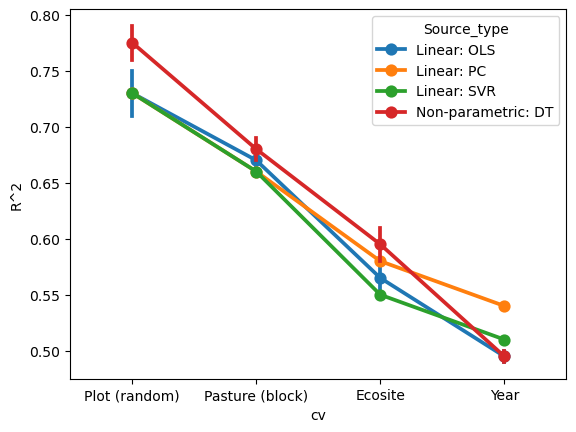

In [11]:
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source_type')

<Axes: xlabel='cv', ylabel='r'>

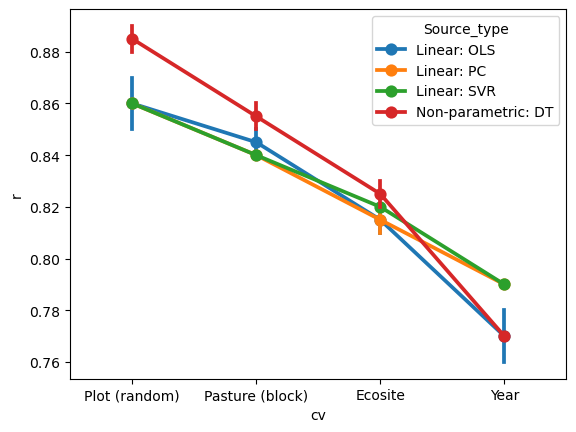

In [12]:
sns.pointplot(x='cv', y='r', data=t_all, hue='Source_type')

<Axes: xlabel='cv', ylabel='MAE_bt'>

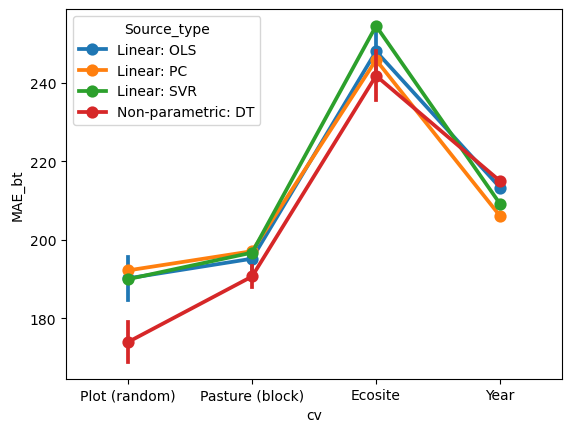

In [13]:
sns.pointplot(x='cv', y='MAE_bt', data=t_all, hue='Source_type')

<Axes: xlabel='cv', ylabel='MAE_bt_pct'>

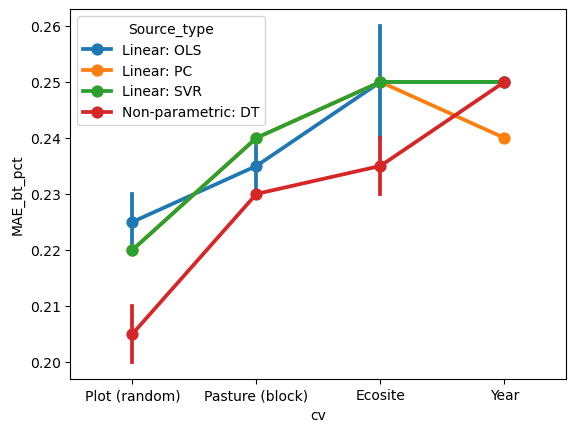

In [14]:
sns.pointplot(x='cv', y='MAE_bt_pct', data=t_all, hue='Source_type')

## PLS/PCA bi-plots

In [19]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [20]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [21]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [22]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [23]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='Greys', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=4))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [24]:
names = ['Plot (random)', 'Pasture (block)', 'Ecosite', 'Year']

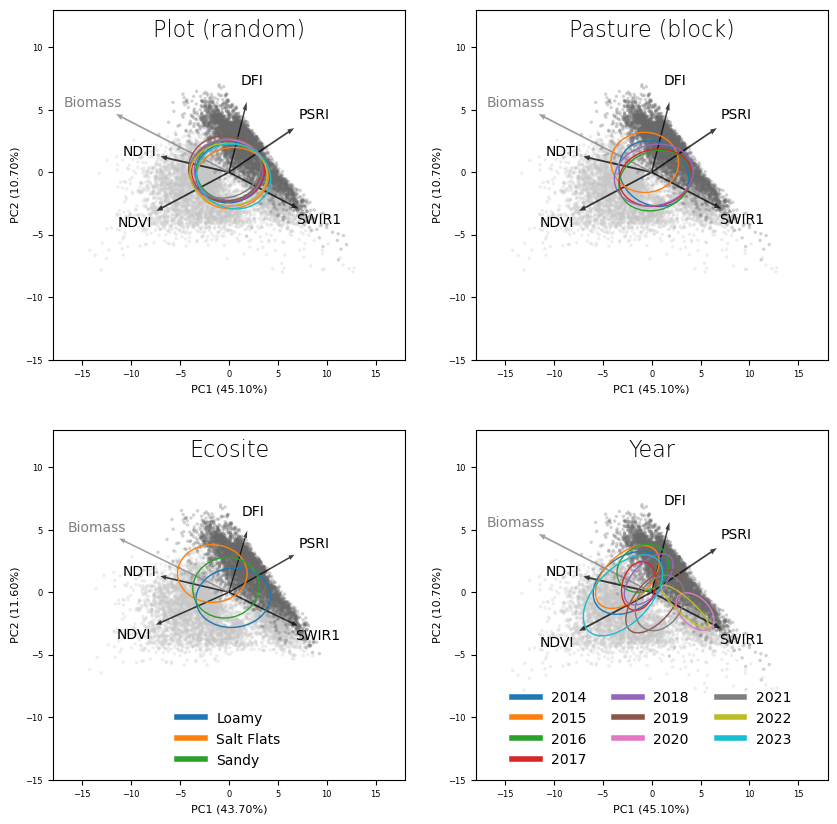

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names[idx],
             n_std=1.0,
             pcs=[1,2])
    leg = axs.flatten()[idx].get_legend()
    if idx > 1:
        leg.set_loc('lower center')
        if idx == 3:
            #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
            axs.flatten()[idx].legend(leg.legend_handles,
                                      [x.get_text() for x in leg.get_texts()], 
                                      ncol=3, loc='lower center', frameon=False)
    else:
        leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.9)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-15, 13))

## Bootstrap by year

In [22]:
df_boots_yr_transect.columns

Index(['Model', 'numb_yrs', 'yr_train', 'yr_test', 'retune_bootstrap', 'MAE',
       'MAPE', 'MAE_pct', 'R2', 'r_coef', 'MAE_plot', 'MAPE_plot',
       'MAE_pct_plot', 'R2_plot', 'r_coef_plot', 'Source_type'],
      dtype='object')

In [23]:
drought_yrs = [2020, 2022]
wet_yrs = [2014, 2015, 2023]

In [24]:
df_boots_drought = df_boots_yr_transect[df_boots_yr_transect['yr_test'].isin(drought_yrs)]
df_boots_drought_notrain = df_boots_drought[~df_boots_drought['yr_train'].apply(lambda x: any([str(i) in x for i in drought_yrs]))]
df_boots_wet = df_boots_yr_transect[df_boots_yr_transect['yr_test'].isin(wet_yrs)]
df_boots_wet_notrain = df_boots_wet[~df_boots_wet['yr_train'].apply(lambda x: any([str(i) in x for i in wet_yrs]))]


In [25]:
df_boots_yr_transect.columns

Index(['Model', 'numb_yrs', 'yr_train', 'yr_test', 'retune_bootstrap', 'MAE',
       'MAPE', 'MAE_pct', 'R2', 'r_coef', 'MAE_plot', 'MAPE_plot',
       'MAE_pct_plot', 'R2_plot', 'r_coef_plot', 'Source_type'],
      dtype='object')

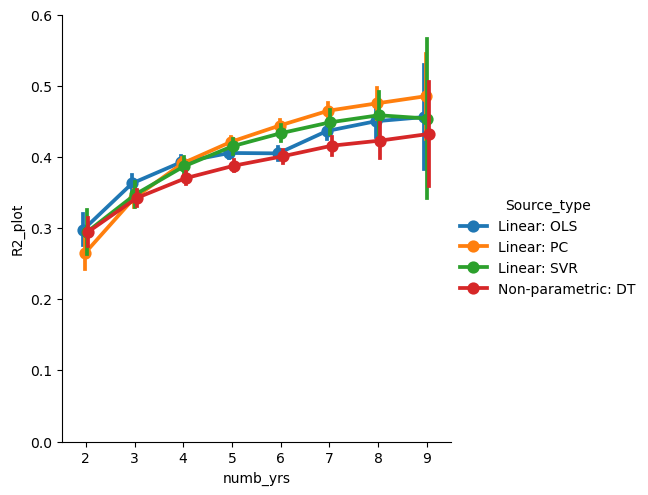

In [26]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type',
                dodge=True,
                data=df_boots_yr_transect,
               errorbar=('se', 2))
g.set(ylim=(0, 0.6))

In [27]:
#df_boots_yr_transect[(df_boots_yr_transect['numb_yrs'] == 6) &
#(df_boots_yr_transect['Source_type'] == 'Linear: OLS')].sort_values('R2_plot').head(20)

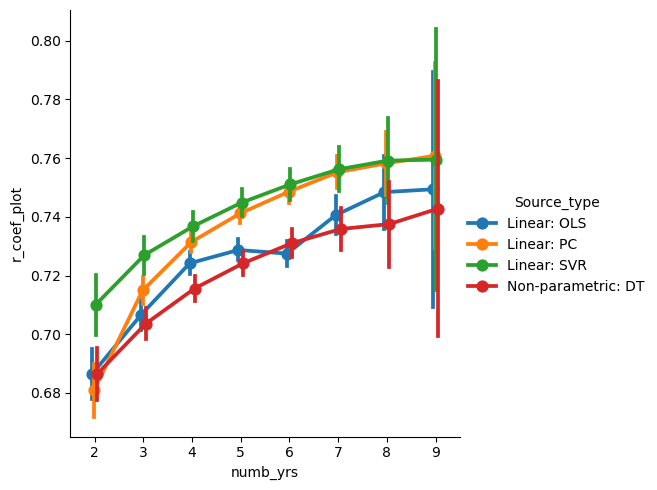

In [28]:
g = sns.catplot(kind='point', x='numb_yrs', y='r_coef_plot', hue='Source_type',
                dodge=True,
                data=df_boots_yr_transect,
               errorbar=('se', 2))
#g.set(ylim=(0, 0.6))

In [29]:
#df_boots_drought[df_boots_drought['numb_yrs'] == 3].sort_values('R2_plot').head(30)

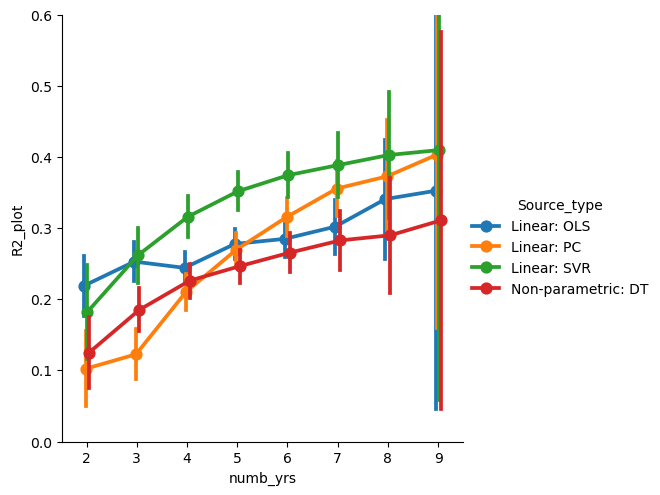

In [30]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type', 
                dodge=True, 
                data=df_boots_drought, errorbar=('se', 2))
g.set(ylim=(0, 0.6))

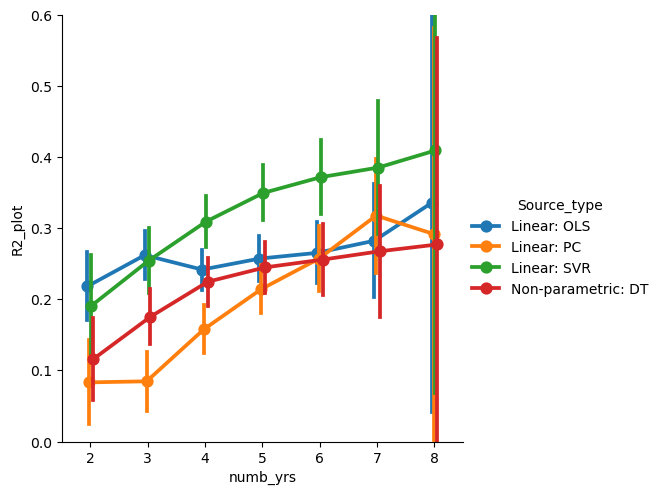

In [31]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type', 
                dodge=True, 
                data=df_boots_drought_notrain,
               errorbar=('se', 2))
g.set(ylim=(0, 0.6))

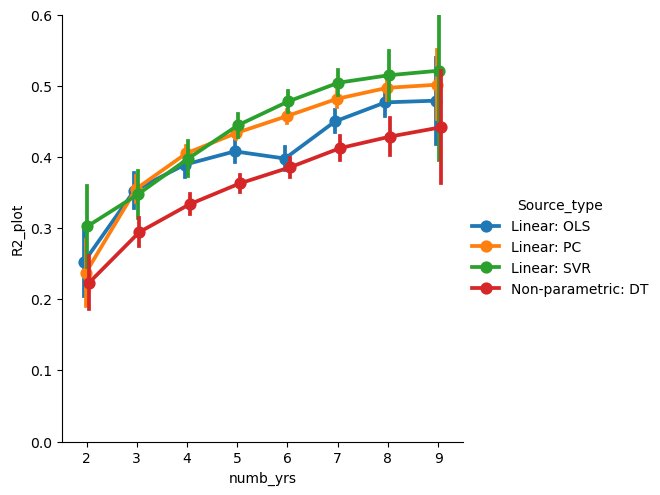

In [32]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type', 
                dodge=True,
                data=df_boots_wet,
               errorbar=('se', 2))
g.set(ylim=(0, 0.6))

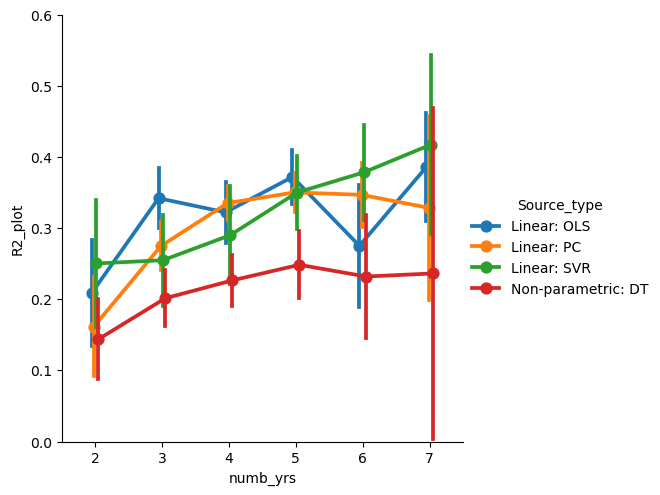

In [33]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type', 
                dodge=True,
                data=df_boots_wet_notrain,
               errorbar=('se', 2))
g.set(ylim=(0, 0.6))

## Euclidean distance of bootstraps

In [11]:
from tqdm import tqdm, notebook
import dask

In [12]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
from hpc_setup import launch_dask
import psutil
interface_prefs = [
    'ibp175s0',
    'ibp59s0',
    'enp24s0f0',
    'ens7f0']
interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
if len(interface) == 0:
    print('ERROR: Preferred interfaces not found on node!')
else:
    print(interface)
num_jobs=128
client = launch_dask(cluster_loc='hpc',
                     num_jobs=num_jobs,
                     num_processes=2,
                     num_threads_per_processes=2,
                     mem_gb_per=12.0,
                     partition='brief-low', 
                     duration='2:00:00',
                     slurm_opts={'interface': interface},
                     wait_proportion=0.25,
                    wait_timeout=240,
                    debug=False)
display(client)

ibp175s0
   setting up cluster on HPC...


<Client: 'tcp://10.1.9.136:43959' processes=30 threads=60, memory=670.50 GiB>

In [151]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [275]:
@dask.delayed
def bootstrap_pls_dist(i, df_boot, df_hls, x_vars=var_names,
                       y_var='sqrt_Biomass_kg_ha', cv_var='Year', train_col='yr_train', test_col='yr_test',
                       centroids_only=True):
    dfs_out = []
    idxs_out = []
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
    y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boot[df_boot[train_col] == i][test_col].unique():
        df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp[cv_var] == yr]
        df_year_centroids = df_year_sub[df_year_sub[cv_var] == yr][pc_names].mean(axis=0)
        df_other_centroids_yrs = df_tmp[df_tmp[cv_var] != yr].groupby('Year')[pc_names].mean()
        ed_yrs = np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids_yrs)**2, axis=1))
        df_other_centroids_all = df_tmp[df_tmp[cv_var] != yr][pc_names].mean()
        ed_all = np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids_all)**2))
        if centroids_only:
            dfs_out.append({train_col: i,
                            test_col: yr,
                            'distances_centroid_all_mean': np.mean(ed_all),
                            'distances_centroid_yrs_mean': np.mean(ed_yrs),
                            'distances_centroid_yrs_min': np.min(ed_yrs)})
        else:
            distances_mean = []
            distances_median = []
            distances_q25 = []
            distances_q10 = []
            distances_q2 = []
            for _, row in df_year_sub.iterrows():
                point = row[pc_names].values.astype(float)
                other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
                # Calculate squared distances using broadcasting
                #sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
                #avg_distances = np.average(np.sqrt((other_points - point) ** 2), weights=r2_scores, axis=1)
                ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
                # Calculate distances using square root
                #distances.append(np.sqrt(squared_distances)) # originally run this way, means are the same, but q's different
                distances_mean.append(np.mean(ec_wdistances))
                distances_median.append(np.median(ec_wdistances))
                distances_q25.append(np.quantile(ec_wdistances, 0.25))
                distances_q10.append(np.quantile(ec_wdistances, 0.10))
                distances_q2.append(np.quantile(ec_wdistances, 0.02))
            dfs_out.append({train_col: i,
                            test_col: yr,
                            'distances_centroid_all_mean': np.mean(ed_all),
                            'distances_centroid_yrs_mean': np.mean(ed_yrs),
                            'distances_centroid_yrs_min': np.min(ed_yrs),
                            'distances_mean': np.mean(distances_mean),
                           'distances_median': np.mean(distances_median),
                           'distances_q25': np.mean(distances_q25),
                            'distances_q10': np.mean(distances_q10),
                           'distances_q2': np.mean(distances_q2)})
            #idxs_out.append(df_boot.loc[(df_boot[train_col] == i) &
            #                (df_boot[test_col] == yr)].index)
    df_out = pd.DataFrame(dfs_out)
    return df_out

In [143]:
i = df_boots_yr_transect['yr_train'].unique()[0]
df_boot = df_boots_yr_transect
df_hls = df_year
x_vars=var_names
y_var='sqrt_Biomass_kg_ha'
cv_var='Year'
train_col='yr_train'
test_col='yr_test'
yrs_train = [int(x) for x in i[1:-1].split(' ')]
X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

pc = PLSRegression(n_components=5)
pc.fit(X_scaled, y)

PLSRegression(n_components=5)

In [146]:
yr = df_boot[df_boot[train_col] == i][test_col].unique()[0]
df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
scores = pc.transform(scaler.transform(df_tmp[var_names]))

pc_names = []
naY = y
r2_scores = []

for j in range(scores.shape[1]):
    pc_names.append('PC' + str(j+1)) 
    df_tmp['PC'+str(j+1)] = scores[:,j]
    Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

df_year_sub = df_tmp[df_tmp[cv_var] == yr]
distances_mean = []
distances_median = []
distances_q25 = []
distances_q10 = []
distances_q2 = []
for _, row in df_year_sub.iterrows():
    point = row[pc_names].values.astype(float)
    other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
    # Calculate squared distances using broadcasting
    ec_distances = np.sqrt(np.sum((other_points - point) ** 2, axis=1))

In [276]:
results_tmp = [bootstrap_pls_dist(x, df_boots_yr_transect, df_year, centroids_only=True) for x in df_boots_yr_transect['yr_train'].unique()]

In [277]:
results = dask.compute(*results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 11.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [142]:
client.cluster.close()
client.close()

In [61]:
#from joblib import Parallel, delayed

In [62]:
#results = list(notebook.tqdm(Parallel(n_jobs=-1, return_as='generator')(delayed(bootstrap_pls_dist)(x, df_boots_yr_transect, df_year) for x in df_boots_yr_transect['yr_train'].unique()), total=len(df_boots_yr_transect['yr_train'].unique())))

  0%|          | 0/1012 [00:00<?, ?it/s]

In [279]:
df_boots2 = pd.merge(df_boots_yr_transect, pd.concat(results), on=['yr_train', 'yr_test'], how='left')
df_boots2['numb_yrs'] = df_boots2['numb_yrs'].astype(str)

In [280]:
#df_boots2[df_boots2['Model'] == 'PLS'].sort_values('distances_centroid_min', ascending=False).head(50)

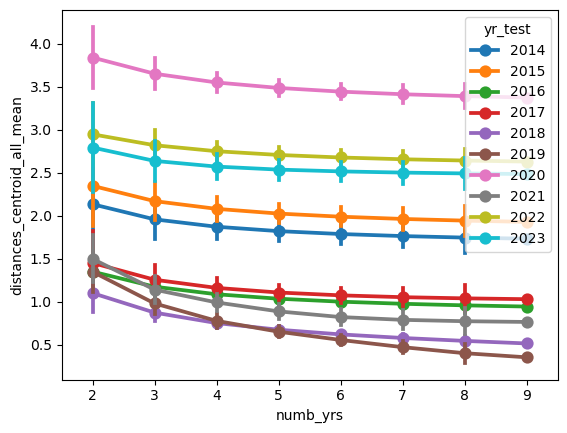

In [283]:
g = sns.pointplot(y='distances_centroid_all_mean', x='numb_yrs', 
                  hue='yr_test', 
                  palette='tab10',
                  errorbar=('se', 2),
                  data=df_boots2[df_boots2['Model'] == 'PLS'])

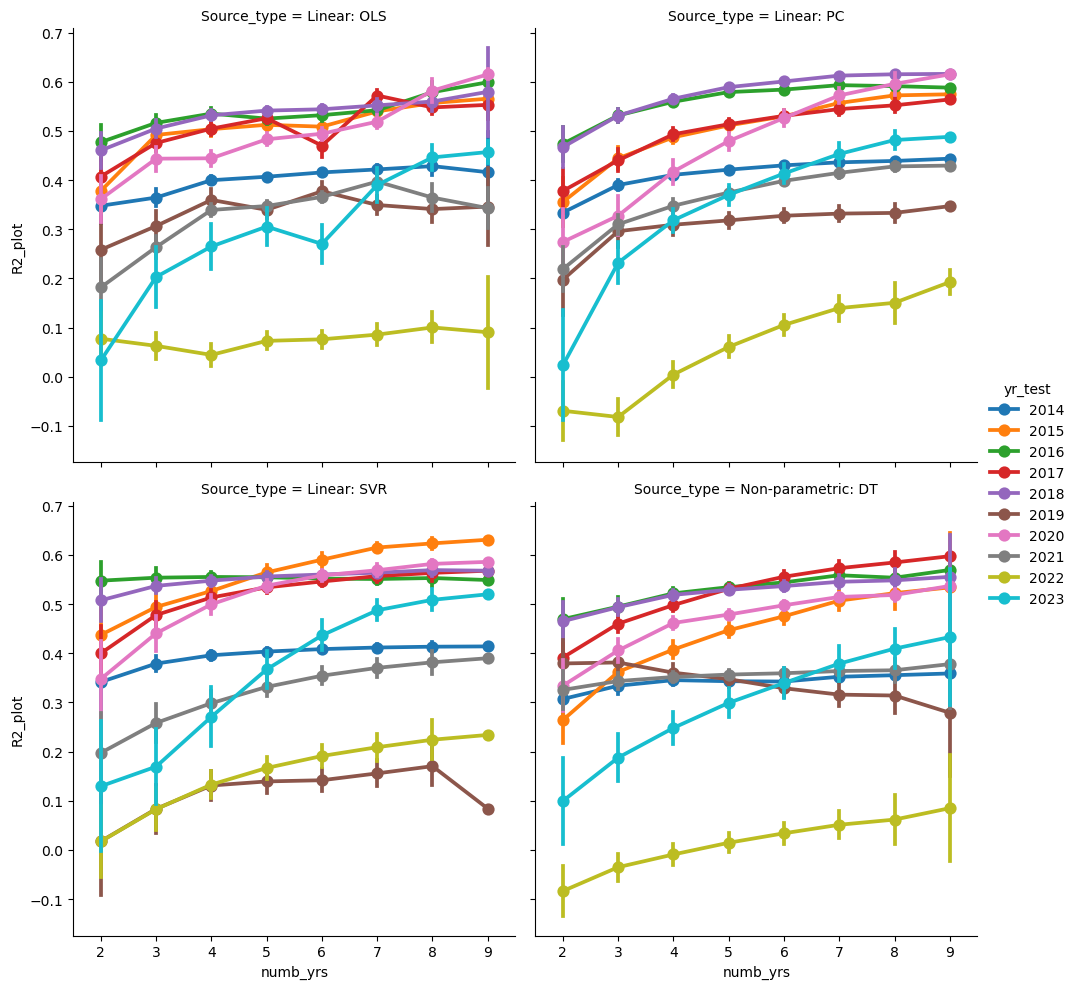

In [171]:
g = sns.catplot(kind='point', y='R2_plot', x='numb_yrs', 
                  hue='yr_test', 
                  palette='tab10',
                  errorbar=('se', 2),
                  data=df_boots2,
                  col='Source_type', col_wrap=2)

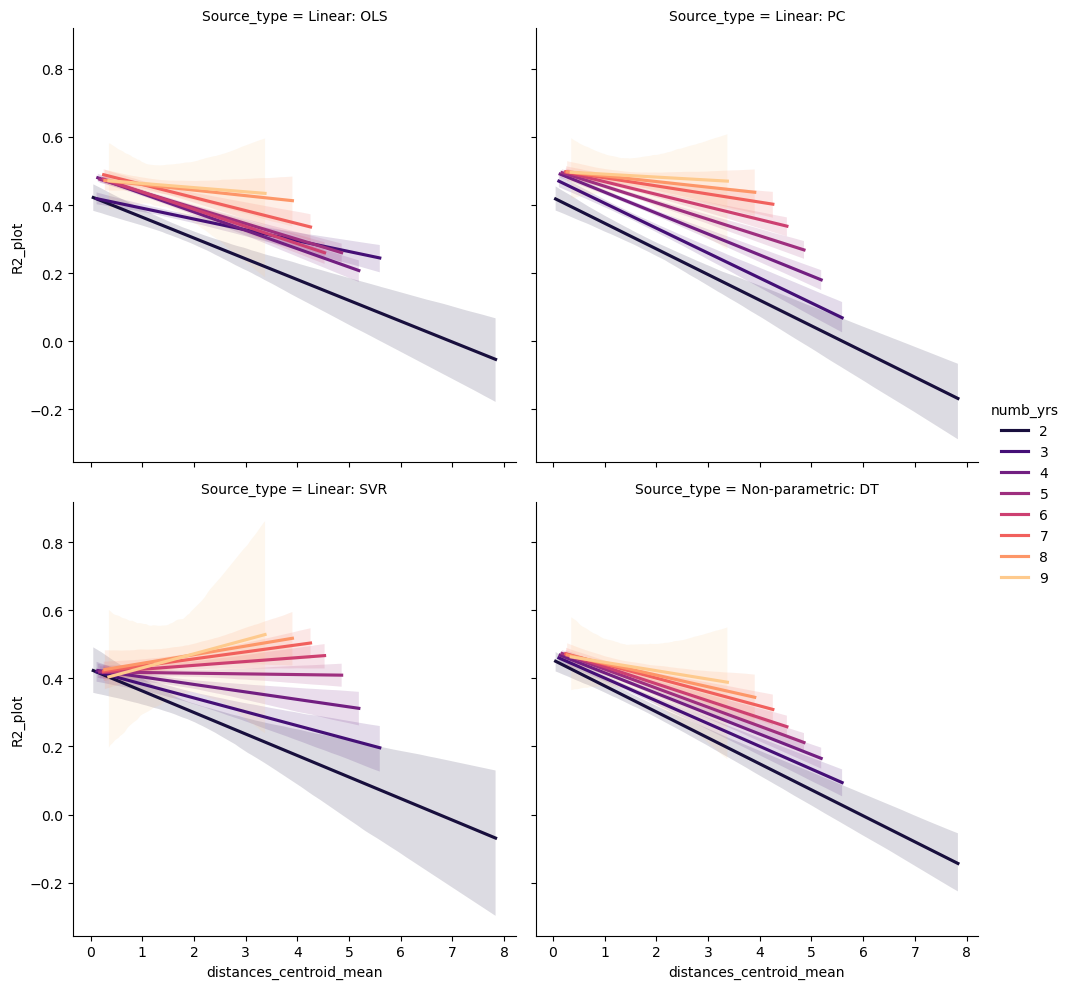

In [274]:
sns.lmplot(x='distances_centroid_mean', y='R2_plot', hue='numb_yrs', scatter=False, 
           data=df_boots2,#[df_boots2['distances_q2'] < 1.5], 
           col='Source_type', col_wrap=2, order=1, ci=95,#[(df_boots2['Model'] == 'RF')],
           palette='magma')

In [167]:
qs = np.round(np.quantile(df_boots2['distances_mean'], np.arange(0, 1.2, 0.2)), 2)
df_boots2['ed_bin'] = pd.cut(df_boots2['distances_mean'],
                           bins=qs,
                           labels=['Bin ('+str(qs[i]) + ' - ' + str(qs[i+1]) + ')' for i in range(5)])

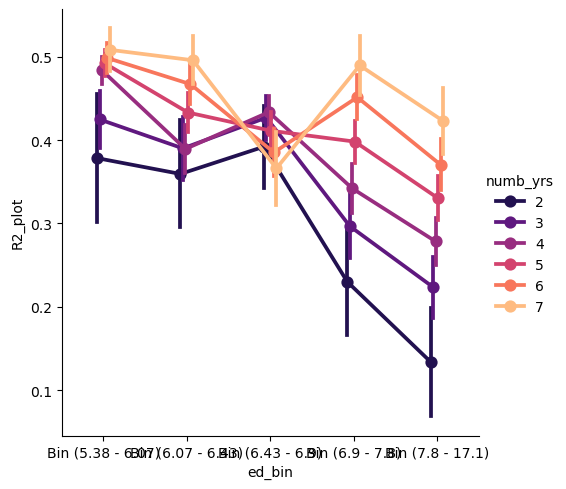

In [168]:
g = sns.catplot(kind='point', x='ed_bin', y='R2_plot', hue='numb_yrs', 
                dodge=True,
                estimator='mean',
                data=df_boots2[(df_boots2['Model'] == 'PLS') &
                (df_boots2['numb_yrs'].isin(np.arange(0, 8).astype(str)))],
                errorbar=('se', 2),
                palette='magma')

In [ ]:
for i in tqdm(df_boots_yr_transect['yr_train'].unique()):
    #print(i)
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_year[df_year['Year'].isin(yrs_train)][var_names]
    y = df_year[df_year['Year'].isin(yrs_train)]['sqrt_Biomass_kg_ha']
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boots_yr_transect[df_boots_yr_transect['yr_train'] == i]['yr_test'].unique():
        #yr = row['yr_test']
        df_tmp = df_year[df_year['Year'].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp['Year'] == yr]
        distances = []
        for _, row in df_year_sub.iterrows():
            point = row[pc_names].values.astype(float)
            other_points = df_tmp[df_tmp['Year'] != yr][pc_names].values.astype(float)
            # Calculate squared distances using broadcasting
            squared_distances = np.sum(r2_scores*((other_points - point) ** 2), axis=1)
            # Calculate distances using square root
            #distances.append(np.sqrt(squared_distances)) # originally run this way, means are the same, but q's different
            distances.append(np.mean(np.sqrt(squared_distances)))
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_mean2'] = np.mean(distances)
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_median2'] = np.median(distances)
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_q12'] = np.quantile(distances, 0.2)    

  1%|          | 5/808 [00:48<2:09:11,  9.65s/it]

In [44]:
#df_boots_yr_transect.head(50)

In [75]:
df_boots_yr_transect['ed_bin'] = pd.cut(df_boots_yr_transect['ed_mean'],
                           bins=np.quantile(df_boots_yr_transect['ed_mean'], np.arange(0, 1.0, 0.1)),
                           labels=['Bin'+str(x+1) for x in range(9)])

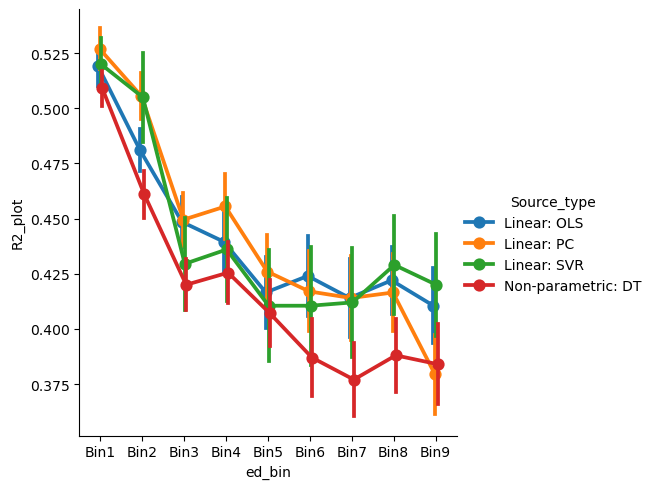

In [77]:
g = sns.catplot(kind='point', x='ed_bin', y='R2_plot', hue='Source_type', 
                dodge=True, estimator='mean',
                data=df_boots_yr_transect,
                errorbar=('se', 2))

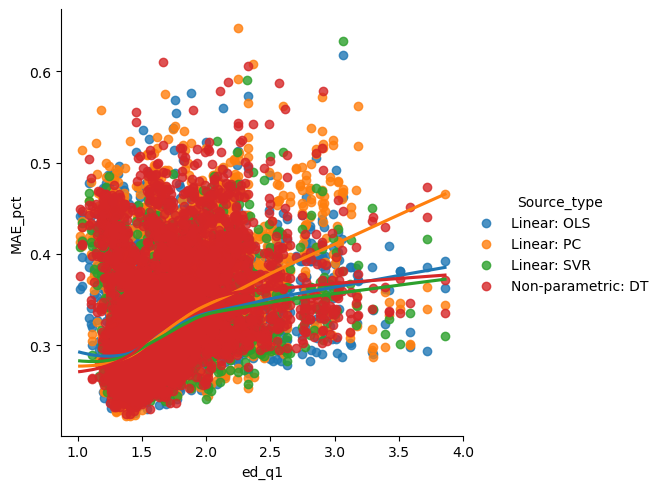

In [39]:
g = sns.lmplot(x='ed_q1', y='MAE_pct', hue='Source_type',
                data=df_boots_yr_transect, scatter=True, lowess=True)
#g.set(ylim=(0, 0.5))

In [77]:
df_tmp

0        True
1        True
2        True
3        True
4        True
        ...  
9642    False
9643    False
9644    False
9645    False
9646    False
Name: Year, Length: 9647, dtype: bool

## Euclidean distance of all years

In [173]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
df_year.columns

Index(['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High',
       'Biomass_kg_ha', 'geometry', 'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2',
       'CPER_2022', 'OLS_2022', 'OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF',
       'GBR', 'DNN', 'kfold', 'cv', 'sqrt_Biomass_kg_ha', 'PC1', 'PC2'],
      dtype='object')

In [174]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [194]:
X = df_year[var_names]
y = df_year['sqrt_Biomass_kg_ha']
features = var_names
X_scaled = StandardScaler().fit_transform(X)

pc = PLSRegression(n_components=len(var_names))
pc.fit(X_scaled, y)
scores = pc.x_scores_

#pc = PCA(n_components=5).fit(X_scaled)
#scores = pc.transform(X_scaled)
#pvars = pc.explained_variance_ratio_

pc_names = []
naY = y
r2_scores = []

for i in range(scores.shape[1]):
    pc_names.append('PC' + str(i+1)) 
    df_year['PC'+str(i+1)] = scores[:,i]
    Y_pred=np.dot(pc.x_scores_[:,i].reshape(-1,1), pc.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

In [195]:
yr = 2023

In [196]:
df_year_centroids = df_year[df_year['Year'] == yr][pc_names].mean(axis=0)
df_other_centroids = df_year[df_year['Year'] != yr].groupby('Year')[pc_names].mean()#.apply(lambda x: x[pc_names].mean(axis=0))
np.mean(np.sqrt(np.sum((df_year_centroids - df_other_centroids)**2, axis=1)))

4.1899200916350035

In [227]:
np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids)**2, axis=1))

Year
2014    0.561329
2015    0.580322
2016    1.607309
2017    1.238247
2018    1.880067
2019    2.168825
2020    4.975786
2021    2.532489
2022    4.275330
dtype: float64

In [229]:
#df_year['ed'] = np.nan
for yr in notebook.tqdm(df_year['Year'].unique()):
    df_year_centroids = df_year[df_year['Year'] == yr][pc_names].mean(axis=0)
    df_other_centroids = df_year[df_year['Year'] != yr].groupby('Year')[pc_names].mean()
    ed = np.min(np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids)**2, axis=1)))
    df_year.loc[df_year['Year'] == yr, 'ed_mean'] = ed

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Year', ylabel='ed_mean'>

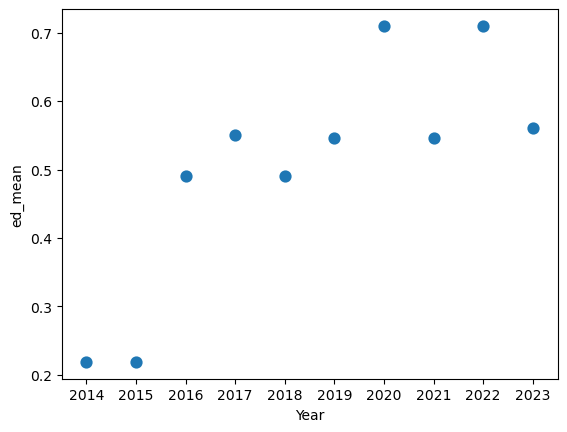

In [230]:
sns.pointplot(x='Year', y='ed_mean', data=df_year, estimator='mean', errorbar=('se', 2), linestyles='none')

In [72]:
df_year['ed'] = np.nan
for yr in notebook.tqdm(df_year['Year'].unique()):
    df_year_sub = df_year[df_year['Year'] == yr]
    for idx, row in df_year_sub.iterrows():
        point = row[pc_names].values.astype(float)
        other_points = df_year[df_year['Year'] != yr][pc_names].values.astype(float)
        # Calculate squared distances using broadcasting
        sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
        # Calculate distances using square root
        distances = (sum_distances)
        df_year.loc[idx, 'ed_mean'] = np.mean(distances)
        df_year.loc[idx, 'ed_median'] = np.median(distances)
        df_year.loc[idx, 'ed_q1'] = np.quantile(distances, 0.2)

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Year', ylabel='ed_mean'>

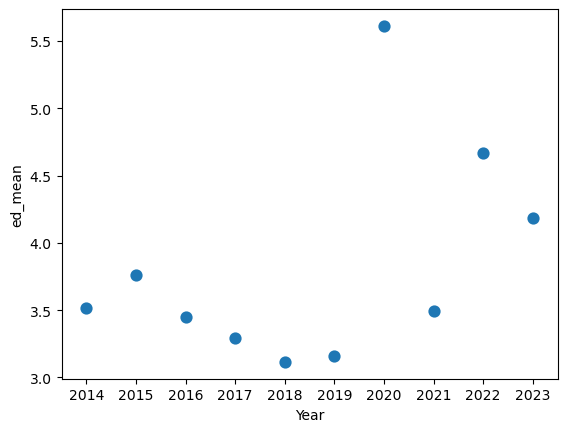

In [190]:
sns.pointplot(x='Year', y='ed_mean', data=df_year, estimator='mean', errorbar=('se', 2), linestyles='none')

In [126]:
import numpy as np

# Single point
point = df_year.iloc[0][pc_names].values.astype(float)

In [132]:
other_points = df_year.iloc[100:1120][pc_names].values.astype(float)

In [133]:
point

array([-8.4854848 , -0.04471776, -2.87938084,  0.47572877, -0.32322992])

In [134]:
# Multiple points (notice the 2D array)
#other_points = np.array([[1, 2], [5, 6]])

# Calculate squared distances using broadcasting
squared_distances = np.sum((other_points - point) ** 2, axis=1)

# Calculate distances using square root
distances = np.sqrt(squared_distances)

# Print the distances (one for each point in other_points)
print(distances)

[3.47536228 4.5406847  5.41667872 ... 2.99712738 5.76151172 4.84195031]


## Euclidean distance of individual predictions

In [26]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
df_year.columns

Index(['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High',
       'Biomass_kg_ha', 'geometry', 'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2',
       'CPER_2022', 'OLS_2022', 'OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF',
       'GBR', 'DNN', 'kfold', 'cv', 'sqrt_Biomass_kg_ha', 'PC1', 'PC2'],
      dtype='object')

In [27]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [82]:
#df_year

In [86]:
@dask.delayed
def bootstrap_pls_dist_indiv(i, df_boot, df_hls, x_vars=var_names,
                       y_var='sqrt_Biomass_kg_ha', cv_var='Year', train_col='yr_train', test_col='yr_test'):
    dfs_out = []
    idxs_out = []
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
    y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boot[df_boot[train_col] == i][test_col].unique():
        df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp[cv_var] == yr]
        #df_year_others = df_tmp[df_tmp[cv_var] != yr]
        distances_mean = []
        distances_median = []
        distances_q25 = []
        distances_q10 = []
        distances_q2 = []
        for _, row in df_year_sub.iterrows():
            point = row[pc_names].values.astype(float)
            other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
            # Calculate squared distances using broadcasting
            #sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
            #avg_distances = np.average(np.sqrt((other_points - point) ** 2), weights=r2_scores, axis=1)
            ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
            distances_mean.append(np.mean(ec_wdistances))
            distances_median.append(np.median(ec_wdistances))
            distances_q25.append(np.quantile(ec_wdistances, 0.25))
            distances_q10.append(np.quantile(ec_wdistances, 0.10))
            distances_q2.append(np.quantile(ec_wdistances, 0.02))
        X_sub = df_year_sub[x_vars]
        X_sub_scaled = scaler.transform(X_sub)
        preds = pc.predict(X_sub_scaled)
        dfs_out.append(pd.DataFrame({
            'numb_yrs': len(i.split(' ')),
            train_col: i,
            test_col: yr,
            'Predicted': preds,
            'Observed': df_year_sub[y_var],
            'distances_mean': distances_mean,
            'distances_median': distances_median,
            'distances_q25': distances_q25,
            'distances_q10': distances_q10,
            'distances_q2': distances_q2
        },
                      index=np.arange(0, len(preds))))
        #idxs_out.append(df_boot.loc[(df_boot[train_col] == i) &
        #                (df_boot[test_col] == yr)].index)
    df_out = pd.concat(dfs_out, ignore_index=True)
    return df_out

In [87]:
results_tmp = [bootstrap_pls_dist_indiv(x, df_boots_yr_transect, df_year) for x in df_boots_yr_transect['yr_train'].unique()]

In [88]:
results = dask.compute(*results_tmp)

In [89]:
df_dist_indiv = pd.concat(results, ignore_index=True)

In [90]:
df_dist_indiv[~df_dist_indiv['Observed'].isnull()].groupby(['numb_yrs', 'yr_test']).count()

yr_train  Predicted  Observed  distances_mean  \
numb_yrs yr_test                                                  
2        2014        31104      31104     31104           31104   
         2015          576        576       576             576   
3        2014        72576      72576     72576           72576   
         2015         1344       1344      1344            1344   
4        2014       108864     108864    108864          108864   
         2015         2016       2016      2016            2016   
5        2014       108864     108864    108864          108864   
         2015         2016       2016      2016            2016   
6        2014        72576      72576     72576           72576   
         2015         1344       1344      1344            1344   
7        2014        31104      31104     31104           31104   
         2015          576        576       576             576   
8        2014         7776       7776      7776            7776   
         2015          144        144       144             144   
9        2014          864        864       864             864   
         2015           16         16        16              16   

                  distances_median  distances_q25  distances_q10  distances_q2  
numb_yrs yr_test                                                                
2        2014                31104          31104          31104         31104  
         2015                  576            576            576           576  
3        2014                72576          72576          72576         72576  
         2015                 1344           1344           1344          1344  
4        2014               108864         108864         108864        108864  
         2015                 2016           2016           2016          2016  
5        2014               108864         108864         108864        108864  
         2015                 2016           2016           2016          2016  
6        2014                72576          72576          72576         72576  
         2015                 1344           1344           1344          1344  
7        2014                31104          31104          31104         31104  
         2015                  576            576            576           576  
8        2014                 7776           7776           7776          7776  
         2015                  144            144            144           144  
9        2014                  864            864            864           864  
         2015                   16             16             16            16

In [91]:
df_dist_indiv# = df_dist_indiv[~df_dist_indiv['Observed'].isnull()].copy()

,numb_yrs,yr_train,yr_test,Predicted,Observed,distances_mean,distances_median,distances_q25,distances_q10,distances_q2
0,2,[2015 2016],2014,41.625272,35.781039,5.035972,5.093309,3.385169,2.289775,1.112819
1,2,[2015 2016],2014,34.011432,39.458992,3.171597,3.241365,1.606537,0.962019,0.498257
2,2,[2015 2016],2014,28.869392,27.313363,2.496591,2.571529,1.497945,0.981752,0.566999
3,2,[2015 2016],2014,27.165781,26.783380,2.868473,3.061992,1.801586,1.283827,0.702491
4,2,[2015 2016],2014,26.751125,35.893127,2.799636,2.942262,1.815973,1.298247,0.739276
...,...,...,...,...,...,...,...,...,...,...
4842789,9,[2014 2015 2016 2017 2018 2019 2020 2021 2022],2023,31.703516,NaN,2.599674,2.395181,1.473005,0.938838,0.495932
4842790,9,[2014 2015 2016 2017 2018 2019 2020 2021 2022],2023,30.379562,NaN,2.543689,2.323436,1.401716,0.880748,0.469110
4842791,9,[2014 2015 2016 2017 2018 2019 2020 2021 2022],2023,30.348155,NaN,2.597443,2.319651,1.368927,0.887362,0.484397
4842792,9,[2014 2015 2016 2017 2018 2019 2020 2021 2022],2023,28.499206,NaN,2.467797,2.222687,1.323576,0.805305,0.449266


In [41]:
#df_dist_indiv['numb_yrs'] = df_dist_indiv.apply(lambda x: len(x['yr_train'].split(' ')), axis=1)

In [48]:
len(df_dist_indiv['Predicted'].iloc[0])

864

In [142]:
client.cluster.close()
client.close()

In [194]:
X = df_year[var_names]
y = df_year['sqrt_Biomass_kg_ha']
features = var_names
X_scaled = StandardScaler().fit_transform(X)

pc = PLSRegression(n_components=len(var_names))
pc.fit(X_scaled, y)
scores = pc.x_scores_

#pc = PCA(n_components=5).fit(X_scaled)
#scores = pc.transform(X_scaled)
#pvars = pc.explained_variance_ratio_

pc_names = []
naY = y
r2_scores = []

for i in range(scores.shape[1]):
    pc_names.append('PC' + str(i+1)) 
    df_year['PC'+str(i+1)] = scores[:,i]
    Y_pred=np.dot(pc.x_scores_[:,i].reshape(-1,1), pc.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

## Individual models

<Axes: xlabel='cv', ylabel='R^2'>

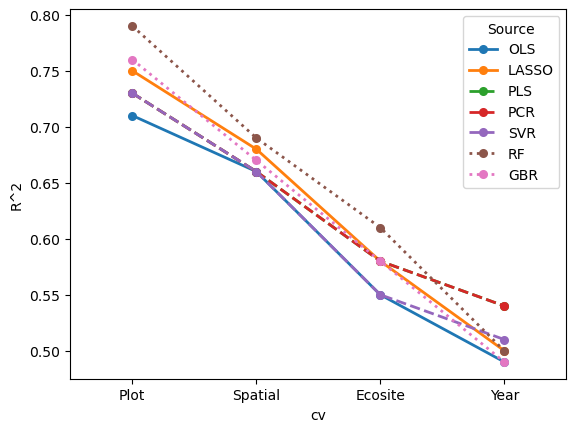

In [8]:
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt'>

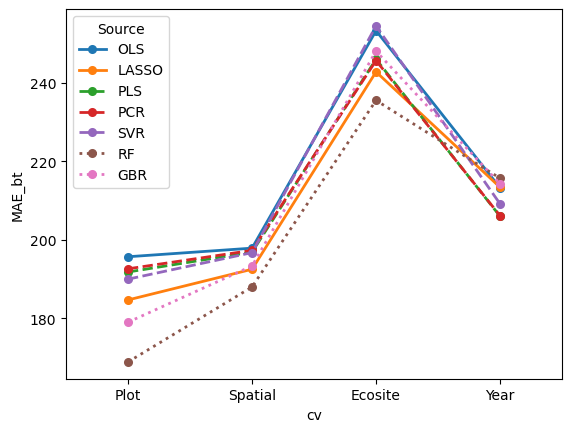

In [9]:
sns.pointplot(x='cv', y='MAE_bt', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt_pct'>

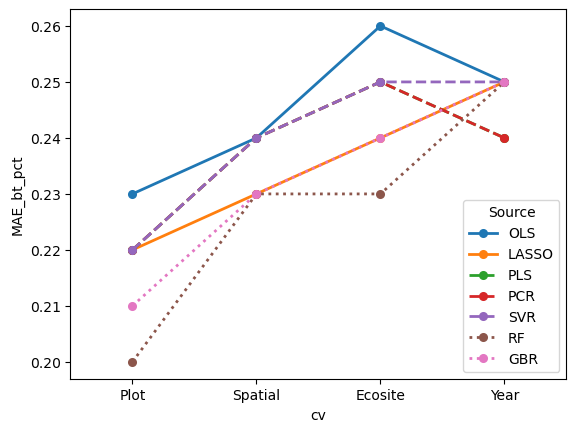

In [10]:
sns.pointplot(x='cv', y='MAE_bt_pct', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='r'>

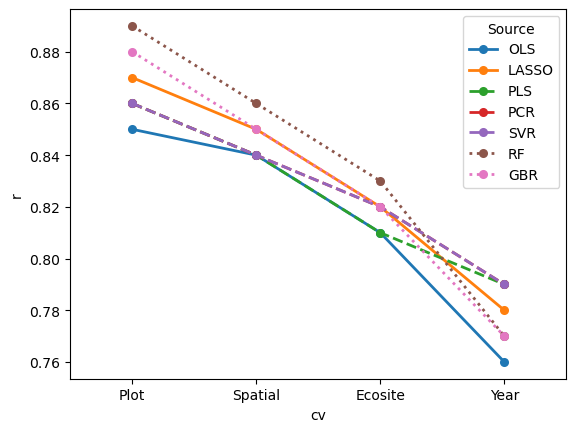

In [11]:
sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)